In [5]:
import os
import tensorflow as tf

In [6]:
#Paths
DATA_PATH = 'Lang'

In [7]:
DATA_PATH

'Lang'

In [8]:
#Files
LANG_M2_PATH = os.path.join(DATA_PATH, 'lang8.train.auto.bea19.m2')
LANG_TXT_PATH = os.path.join(DATA_PATH, 'lang8.train.auto.bea19.txt')
DATA_CSV_PATH = os.path.join(DATA_PATH, "data.csv")

In [9]:
# Apply the edits of a single annotator to generate the corrected sentences.
import pandas as pd


def main():
    """
    this function stores the correct sentence line by line in as txt file with file name lang8.train.auto.bea19.m2
    """
    m2 = open(LANG_M2_PATH).read().strip().split("\n\n")
    out = open(LANG_TXT_PATH, "w")
    # Do not apply edits with these error types
    skip = {"noop", "UNK", "Um"}

    for sent in m2:
        sent = sent.split("\n")
        cor_sent = sent[0].split()[1:]  # Ignore "S "
        edits = sent[1:]
        offset = 0
        for edit in edits:
            edit = edit.split("|||")
            if edit[1] in skip: continue  # Ignore certain edits
            coder = int(edit[-1])
            if coder != 0: continue  # Ignore other coders
            span = edit[0].split()[1:]  # Ignore "A "
            start = int(span[0])
            end = int(span[1])
            cor = edit[2].split()
            cor_sent[start + offset:end + offset] = cor
            offset = offset - (end - start) + len(cor)
        out.write(" ".join(cor_sent) + "\n")


main()



In [10]:
#preprocessing incorrect sentences

file1 = open(LANG_M2_PATH)
s1 = file1.read()

each_sent = s1.split("\n\n")

incorrect = []
for i in range(len(each_sent)):
    temp = each_sent[i].split("\n")
    temp = temp[0]
    temp = temp.split(" ")
    temp = temp[1:]  # ignore S
    temp = ' '.join(temp)
    incorrect.append(temp)



In [11]:
#preprocessing correct sentences

file2 = open(LANG_TXT_PATH, "r")
s2 = file2.read()

correct = s2.split("\n")

# storing correct and incorrect sentence pair into dataframe
df = pd.DataFrame()
df["correct"] = correct
df["incorrect"] = incorrect

In [12]:
#Remove the same pair of correct and incorrect sentences
print(df.shape)
index = []
for i in range(len(df.values)):
    if df.values[i][0] == df.values[i][1]:
        index.append(i)

df = df.drop(index)
print(df.shape)

(1037562, 2)
(498360, 2)


In [13]:
# ckeck if any null value is present
df.isnull().values.any()

df.dropna(inplace=True)

# ckeck if any duplicate value is present
df.duplicated().values.any()

df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(496339, 2)

In [14]:
print(df.values)


[['And he took in my favorite subjects like soccer .'
  'And he took in my favorite subject like soccer .']
 ['Actually , he was the one who let me know about Lang - 8 . .'
  'Actually , who let me know about Lang - 8 was him .']
 ['His Kanji ability is much better than mine .'
  "His Kanji 's ability is much better than me ."]
 ...
 ['I think it is important to like coriander in order to enjoy Thai food .'
  'I think it is important thing to become to like pakuchi - ( green leaf ) in order to enjoy thailand food .']
 ['I went to Umeda station for dating yesterday .'
  'Yesterday , I went to Umeda station to date .']
 ['she said she want to change the meeting time to evenig .'
  'It said , she want to make the meeting time at evenig .']]


In [15]:
#Remove unnecessary or junk character from the dataset
import re


def clean(text):
    """
    takes string as input and
    removes characters inside (),{},[] and <>
    removes characters like -+@#^/|*(){}$~`
    we not not removing ,.!-:;"' as these characters are present in english language
    """
    text = re.sub('<.*>', '', text)
    text = re.sub('\(.*\)', '', text)
    text = re.sub('\[.*\]', '', text)
    text = re.sub('{.*}', '', text)
    text = re.sub("[-+@#^/|*(){}$~`<>=_]", "", text)
    text = text.replace("\\", "")
    text = re.sub("\[", "", text)
    text = re.sub("\]", "", text)
    text = re.sub("[0-9]", "", text)
    return text


text = clean("kofi(hi)9*hj")
text

'kofihj'

In [16]:
from pandas.core.dtypes.common import is_string_dtype

# df['correct'] = df['correct'].map(lambda x: x.lstrip('+-').rstrip('aAbBcC'))
for col in df.columns:
    df[col] = df[col].str.replace('<.*>', '')
    df[col] = df[col].str.replace('\(.*\)', '')
    df[col] = df[col].str.replace('\[.*\]', '')
    df[col] = df[col].str.replace('{.*}', '')
    df[col] = df[col].str.replace('[-+@#^/|*(){}$~`<>=_]', '')
    df[col] = df[col].str.replace('\\', '')
    df[col] = df[col].str.replace('\[', '')
    df[col] = df[col].str.replace('\]', '')
    df[col] = df[col].str.replace('[0-9]', '')

C:\Users\Emmanuel\AppData\Local\Temp/ipykernel_22632/3951536476.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('<.*>', '')
C:\Users\Emmanuel\AppData\Local\Temp/ipykernel_22632/3951536476.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('\(.*\)', '')
C:\Users\Emmanuel\AppData\Local\Temp/ipykernel_22632/3951536476.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('\[.*\]', '')
C:\Users\Emmanuel\AppData\Local\Temp/ipykernel_22632/3951536476.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('{.*}', '')
C:\Users\Emmanuel\AppData\Local\Temp/ipykernel_22632/3951536476.py:9: FutureWarning: The default value of regex will change from True to False in a future version.


In [17]:
#store pre-processed data into csv file named data.csv
df.to_csv(DATA_CSV_PATH, index=False)

In [19]:
ds = tf.data.experimental.make_csv_dataset(DATA_CSV_PATH, header=True, shuffle=True, batch_size=1)

In [73]:
ds

<PrefetchDataset shapes: OrderedDict([(correct, (1,)), (incorrect, (1,))]), types: OrderedDict([(correct, tf.string), (incorrect, tf.string)])>

Visualize Data

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

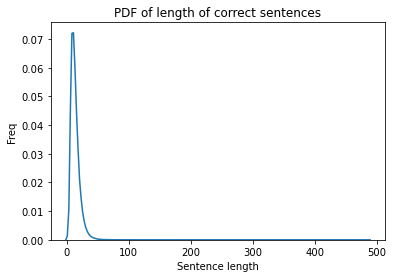

In [22]:
corr_len = df["correct"].str.split().apply(len)
corr_len = list(corr_len)
sns.kdeplot(corr_len)
plt.xlabel("Sentence length")
plt.ylabel("Freq")
plt.title("PDF of length of correct sentences")
plt.show()

In [37]:
corr_len

496339

In [35]:
from numpy import percentile

percentile(0, 100, 10, corr_len)

AxisError: axis 10 is out of bounds for array of dimension 0

In [36]:
percentile(90, 100, 1, corr_len)


AxisError: axis 1 is out of bounds for array of dimension 0

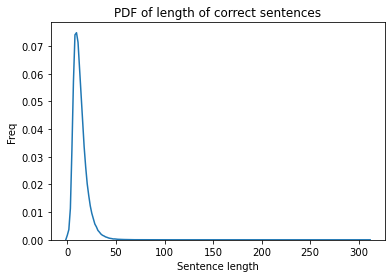

In [38]:
incorr_len = df["incorrect"].str.split().apply(len)
incorr_len = list(incorr_len)
sns.kdeplot(incorr_len)
plt.xlabel("Sentence length")
plt.ylabel("Freq")
plt.title("PDF of length of correct sentences")
plt.show()


Split data to training, validation and testing set

In [13]:
#Split dataframe to training, validation and test data
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd


def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [14]:
train_df, val_df, test_df = train_validate_test_split(df, .8, .15)

In [15]:
print(train_df)
print(val_df)
print(test_df)


                                                  correct  \
397325  Here , I introduce a website called  Japanese ...   
198916  Nevertheless , till today , I did n't tell her...   
175964  However I have noticed a sad thing about Japan...   
108816                         I 'm available on Monday .   
473713               I was so looking forward to this ! !   
...                                                   ...   
195284                        Last week , I got a raise     
57623   Well , I do n't know why I wrote this , but I ...   
382607                     This diary is kind of a moan .   
273625  I hear that the custom comes from a belief tha...   
224292  I 'm angry at my beauty artist for cutting my ...   

                                                incorrect  
397325  Here , I introduce a website , called  Japanes...  
198916  Nevertheless , till today , I do n't tell her ...  
175964  However I have to notice a sad thing about Jap...  
108816                     

In [42]:
def train_validate_test_split_ds(ds, train_percent=.6, validate_percent=.2, seed=None):
    ds_size = len(df)
    print(ds_size)
    train_size = int(0.7 * ds_size)
    val_size = int(0.15 * ds_size)
    test_size = int(0.15 * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [43]:
train_ds, val_ds, test_ds = train_validate_test_split_ds(ds, .8, .15)

496339


In [44]:
print(train_ds)

<TakeDataset shapes: OrderedDict([(correct, (1,)), (incorrect, (1,))]), types: OrderedDict([(correct, tf.string), (incorrect, tf.string)])>


In [ ]:
print(val_ds)

In [ ]:
print(test_ds)

In [57]:
#Vectorize df
from tensorflow.python.keras.layers import TextVectorization

VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')


In [46]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)


In [59]:
ndims = tf.expand_dims('correct', -1)
binary_vectorize_layer(ndims)

<tf.Tensor: shape=(1, 10000), dtype=float32, numpy=array([[1., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [78]:



def binary_vectorize_text(gh):
    print(tf.strings.split((gh['correct']), sep=''))
    text = tf.expand_dims("correct", -1)
    incorrect = tf.expand_dims("incorrect", -1)
    return binary_vectorize_layer(text), binary_vectorize_layer(incorrect)


In [27]:
def int_vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return int_vectorize_layer(text), label


In [64]:
dict(train_df)


{'correct': 328921    American tornados are also American size .  So...
 116383    I had a good time because we talked about a sy...
 234247    His visa was going to expire soon so he had to...
 364534    To decorate the room and prepare for the games...
 482950         But most importantly , it is really funny : 
                                 ...                        
 233391     So  years remain after retirement , on average .
 462350    After reading my friend 's diary I had the fee...
 326194                 I keep falling asleep with them in .
 324368    My eyes turn in red and I have fur on my tongue .
 260693                        Cell phones are very useful .
 Name: correct, Length: 397071, dtype: object,
 'incorrect': 328921    American tornades are also American sizes .  S...
 116383    I had a good time because we told about sysyte...
 234247    his visa was going to be expired soon so He ha...
 364534    To decorate the room and prepare for games , e...
 482950      B

In [22]:
#convert df to ds
# train_ds = (
#     tf.data.Dataset.from_tensor_slices(
#         (
#             train_df
#         )
#     )
# )
#
# val_ds = (
#     tf.data.Dataset.from_tensor_slices(
#         (
#             val_df
#         )
#     )
# )
#
# test_ds = (
#     tf.data.Dataset.from_tensor_slices(
#         (
#             test_df)
#     )
# )


In [64]:
for example, label in train_ds.take(10):
  print('text: ', example)
  print('label: ', label)


text:  correct
label:  incorrect
text:  correct
label:  incorrect
text:  correct
label:  incorrect
text:  correct
label:  incorrect
text:  correct
label:  incorrect
text:  correct
label:  incorrect
text:  correct
label:  incorrect
text:  correct
label:  incorrect
text:  correct
label:  incorrect
text:  correct
label:  incorrect


In [72]:
train_ds["correct"]

TypeError: 'TakeDataset' object is not subscriptable

TypeError: dataset length is unknown.

In [79]:
# As a final preprocessing step, you will apply the TextVectorization
# layers you created earlier to the training, validation, and test sets:
 # As a final preprocessing step, you will apply the TextVectorization
# layers you created earlier to the training, validation, and test sets:

binary_train_ds = train_ds.map(binary_vectorize_text)
binary_val_ds = val_ds.map(binary_vectorize_text)
binary_test_ds = test_ds.map(binary_vectorize_text)

# int_train_ds = raw_train_ds.map(int_vectorize_text)
# int_val_ds = raw_val_ds.map(int_vectorize_text)
# int_test_ds = raw_test_ds.map(int_vectorize_text)


tf.RaggedTensor(values=Tensor("StringSplit/StringSplitV2:1", shape=(None,), dtype=string), row_splits=Tensor("StringSplit/RaggedFromValueRowIds/RowPartitionFromValueRowIds/concat:0", shape=(None,), dtype=int64))
tf.RaggedTensor(values=Tensor("StringSplit/StringSplitV2:1", shape=(None,), dtype=string), row_splits=Tensor("StringSplit/RaggedFromValueRowIds/RowPartitionFromValueRowIds/concat:0", shape=(None,), dtype=int64))
tf.RaggedTensor(values=Tensor("StringSplit/StringSplitV2:1", shape=(None,), dtype=string), row_splits=Tensor("StringSplit/RaggedFromValueRowIds/RowPartitionFromValueRowIds/concat:0", shape=(None,), dtype=int64))


In [53]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, incorrect: text))


TypeError: in user code:


    TypeError: <lambda>() missing 1 required positional argument: 'incorrect'


In [62]:
x_train
print(y_train)

218663

In [48]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [55]:
vectorizer = CountVectorizer(binary=True)
x_train_vectors = vectorizer.fit_transform(x_train).todense()
# list(map(binary_vectorize_text, x_train))
y_train_vectors = vectorizer.fit_transform(y_train).todense()
x_val_vectors = vectorizer.fit_transform(x_val).todense()
y_val_vectors = vectorizer.fit_transform(y_val).todense()
test_vectors = vectorizer.transform(x_test).todense()


MemoryError: Unable to allocate 165. GiB for an array with shape (397071, 55822) and data type int64

In [53]:
print(len(x_train_vectors))
print(len(y_train_vectors))


TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [54]:
x_train_vectors = tf.sparse.reorder(x_train_vectors)
y_train_vectors = tf.sparse.reorder(y_train_vectors)

TypeError: Input must be a SparseTensor.

In [39]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

In [52]:
#Train the model
binary_model = tf.keras.Sequential([layers.Dense(4)])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

history = binary_model.fit(
    x_train_vectors, y_train_vectors, validation_data = (tf.sparse.reorder(x_val_vectors), tf.sparse.reorder(y_train_vectors)), epochs=10)


InvalidArgumentError: indices[3] = [0,6818] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]